In [1]:
import time
from pathlib import Path
from operator import itemgetter

import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
import os
import torch

import scSLAT
from scSLAT.model import Cal_Spatial_Net, load_anndatas, run_SLAT_mlp_AGF, spatial_match, run_SLAT, compute_lisi_for_adata, run_SLAT_AGF_contrast
from scSLAT.viz import match_3D_multi, hist, Sankey, build_3D
from scSLAT.metrics import region_statistics

In [2]:
adata_1=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\BARISTA_slice2_banksy_data.h5ad")
adata_1.var_names_make_unique(join="++")
adata_1

AnnData object with n_obs × n_vars = 2042 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'layer_colors'
    obsm: 'X_pca', 'spatial'

In [3]:
adata_2=sc.read_h5ad(r"D:\ppppaper\SLAT\SLAT-main\SLAT-main\my_benchmark\BARISTA_slice3_banksy_data.h5ad")
adata_2.var_names_make_unique(join="++")
adata_2

AnnData object with n_obs × n_vars = 1690 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'Region', 'ground_truth', 'banksy', 'UMAP_1', 'UMAP_2'
    uns: 'layer_colors'
    obsm: 'X_pca', 'spatial'

In [6]:
spot_size = 20
pathology_color = [
    "#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD", "#8C564B",
    "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF", "#AEC7E8", "#FFBB78",
    "#98DF8A", "#FF9896", "#C5B0D5", "#C49C94", "#F7B6D2", "#C7C7C7",
    "#DBDB8D", "#9EDAE5", "#1F9B99", "#FFCD56", "#33A02C", "#FB9A99",
    "#A6CEE3"
]

[<AxesSubplot: xlabel='spatial1', ylabel='spatial2'>]

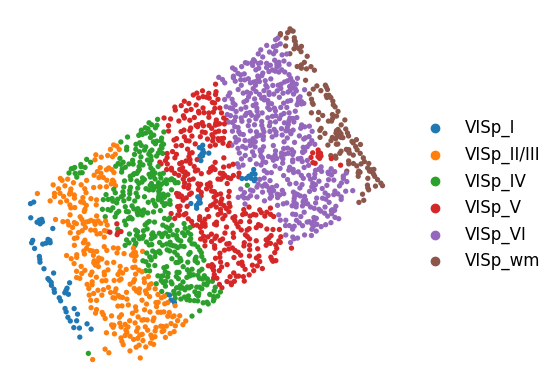

In [7]:
sc.pl.spatial(adata_2, img_key=None, color=['banksy'], title=[''],
                legend_fontsize=12, show=False, frameon=False, palette=pathology_color,
                spot_size=spot_size)

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

# 获取真实标签和预测标签
true_labels = adata_2.obs['ground_truth']
pred_labels = adata_2.obs['banksy']

# 生成分类报告
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

# 生成混淆矩阵
print("Confusion Matrix:")
print(confusion_matrix(true_labels, pred_labels))

Classification Report:
              precision    recall  f1-score   support

      VISp_I       0.60      0.74      0.66        61
 VISp_II/III       0.91      0.72      0.81       379
     VISp_IV       0.74      0.73      0.73       377
      VISp_V       0.71      0.76      0.73       336
     VISp_VI       0.85      0.95      0.90       409
     VISp_wm       0.94      0.91      0.92       128

    accuracy                           0.80      1690
   macro avg       0.79      0.80      0.79      1690
weighted avg       0.81      0.80      0.80      1690

Confusion Matrix:
[[ 45  15   1   0   0   0]
 [  5 274  95   5   0   0]
 [  3  11 276  87   0   0]
 [ 22   0   3 256  55   0]
 [  0   0   0  13 388   8]
 [  0   0   0   0  11 117]]


In [9]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 计算 ARI
ari_score = adjusted_rand_score(true_labels, pred_labels)
print(f"Adjusted Rand Index (ARI): {ari_score:.8f}")

# 计算 NMI
nmi_score = normalized_mutual_info_score(true_labels, pred_labels)
print(f"Normalized Mutual Information (NMI): {nmi_score:.8f}")

Adjusted Rand Index (ARI): 0.60622029
Normalized Mutual Information (NMI): 0.66229852


In [10]:
adata_1.obsm["X_umap"] = adata_1.obs[['UMAP_1', 'UMAP_2']].values
adata_2.obsm["X_umap"] = adata_2.obs[['UMAP_1', 'UMAP_2']].values
adata_combined = adata_1.concatenate(adata_2, batch_key="slice_name", batch_categories=['slice_1','slice_2'])

d:\Anaconda\envs\scSLAT\lib\site-packages\anndata\_core\anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
d:\Anaconda\envs\scSLAT\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


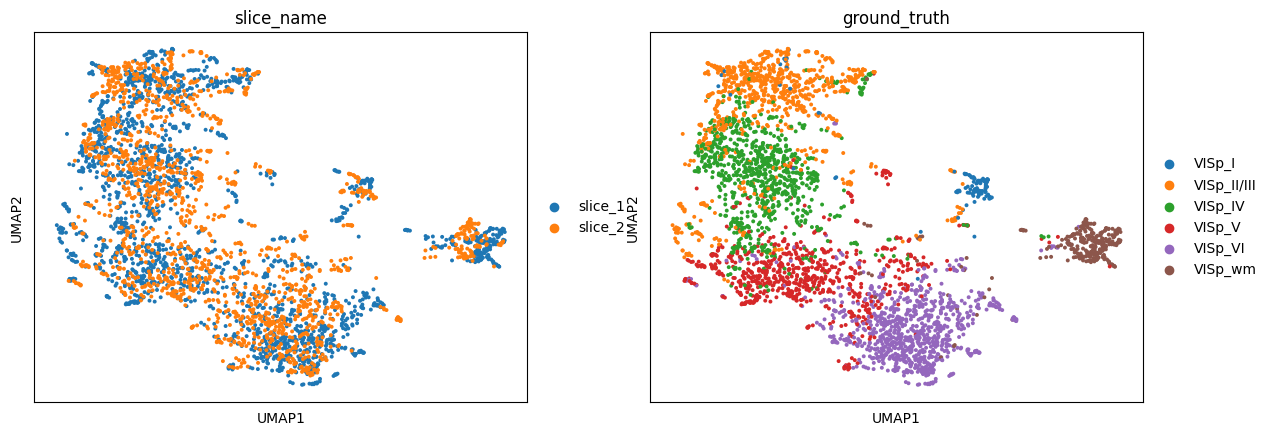

In [11]:
sc.pl.umap(adata_combined, color=['slice_name', 'ground_truth'])

In [12]:
lisi_scores = compute_lisi_for_adata(adata_combined, obsm_key='X_pca', obs_key_list=['ground_truth', 'slice_name'])
print("LISI Scores:\n", lisi_scores)

LISI Scores:
 {'cLISI': 1.4492414249874581, 'iLISI': 1.6193634137102406}
